# Discovery of Non-Linear Pendulum Dynamics using SODAs

This notebook documents the process of discovering the equations of motion of a  non-linear pendulum (away from small angle approximations) from pixel data of a video footage of an experimen where a singel pendulum which is part of newton's craddle is swingin from different initial conditions. The footage was shot on an Iphone 16pro with 120 fps.  

## Workflow
1. **Loading Video Footage**: The video footage of the pendulum is loaded using `cv2`, an open-source computer vision package in Python.
2. **Tracking the Pendulum Bob**: The x and y coordinates of the pendulum bob are tracked. The pivot point is centered at the origin.
3. **Normalization**: The length of the pendulum is normalized to be 1.
4. **Data Processing**: SODAs is applied to the (x,y) coordinates to find the algebraic constraints in the system using.
5. **Equation Discovery**: After the coordinat system is discovered, we transition into polar coordinates where the appropriate library functions are craeted to discover the polar equation of the pendulum.

In [1]:
import os, sys

path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(path_to_add)
print(os.path.join(path_to_add, "daeFinder"))
sys.path.append(os.path.join(path_to_add, "daeFinder"))


import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator
import sympy
from dae_finder import construct_reduced_fit_list

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp




from matplotlib import pyplot as plt
from dae_finder import smooth_data
from dae_finder import add_noise_to_df
from sklearn import decomposition
from sklearn.linear_model import LinearRegression
from dae_finder import get_simplified_equation_list
from dae_finder import get_refined_lib, remove_paranth_from_feat
from dae_finder import AlgModelFinder
from dae_finder import sequentialThLin, AlgModelFinder
from dae_finder import PolyFeatureMatrix
from copy import deepcopy



/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder


# Tracking from Pendulum video footage

- Run this section only once to get the (x,y) coordinates. 
- If this section is ran once, move to Loading of data directly.

### Finding the reference point (hook of pendulum)

In [ ]:
import cv2
import numpy as np

def pick_color(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:  # Left mouse click
        pixel = frame[y, x]
        hsv_pixel = cv2.cvtColor(np.uint8([[pixel]]), cv2.COLOR_BGR2HSV)[0][0]
        print(f"HSV Color at ({x}, {y}): {hsv_pixel}")
ind = 9
video_path = "data/pendulum_recording_{}.mov".format(ind)
cap = cv2.VideoCapture(video_path)

cv2.namedWindow("Frame")
cv2.setMouseCallback("Frame", pick_color)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    cv2.imshow("Frame", frame)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
# center = (793, 24)
center_dict = {}
center_dict[7] = ((1126+1122)/2, (2+128)/2)
center_dict[8] = ((993+990)/2, (44+165)/2)
center_dict[9] = ((993+990)/2, (44+165)/2)
center_dict[10] = ((962+965)/2, (44+176)/2)



color = [120, 255, 243]

### Tracking the pendulum

### Color based detection

In [ ]:
import cv2
import numpy as np
import pandas as pd

# Define HSV color range for the pendulum bob (Replace with detected values)
# lower_color = np.array([100, 150, 0])  # Lower bound for blue shades
# upper_color = np.array([140, 255, 255])  # Upper bound for blue shades

lower_color = np.array([0, 0, 0])  # Replace with detected values
upper_color = np.array([5, 5, 5])

for ind in [5]:
    # ind =1
    video_path = "data/pendulum_recording_{}.mov".format(ind)

    cap = cv2.VideoCapture(video_path)

    # Get FPS (frames per second) from video
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_time = 1 / fps  # Time interval between frames

    # List to store detected coordinates with time
    positions = []
    frame_count = 0  # To track frame number

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1  # Track frame number
        time = frame_count * frame_time  # Compute time in seconds

        # Convert frame to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Create a mask for the pendulum bob's color
        mask = cv2.inRange(hsv, lower_color, upper_color)

        # Perform morphological operations
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # Find contours from the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Select the largest contour (assumed to be the pendulum bob)
            largest_contour = max(contours, key=cv2.contourArea)

            # Get bounding box around the detected bob
            x, y, w, h = cv2.boundingRect(largest_contour)

            # Calculate center of the bounding box (Pendulum bob's position)
            center_x = x + w // 2
            center_y = y + h // 2

            # Store time and coordinates
            positions.append([time, center_x, center_y])

            # Draw tracking marker
            cv2.circle(frame, (center_x, center_y), 5, (0, 255, 0), -1)
            cv2.putText(frame, f"({center_x}, {center_y})", (center_x + 10, center_y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Show the tracking result
        cv2.imshow("Pendulum Tracking", frame)

        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    # Convert positions to a DataFrame and save as CSV
    df = pd.DataFrame(positions, columns=["t", "X", "Y"])
    df.to_csv("data/pendulum_recording_{}.csv".format(ind), index=False)

    print("Pendulum position data with time saved to data/pendulum_time_series_damped_{}.csv".format(ind))

### Motion based detection

In [1]:
import cv2
import numpy as np
import pandas as pd

for ind in [8,9,10]:
    video_path = "data/pendulum_recording_{}.mov".format(ind)
    cap = cv2.VideoCapture(video_path)

    # Get FPS (frames per second) from video
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_time = 1 / fps  # Time interval between frames

    # Background subtractor
    fgbg = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50, detectShadows=False)

    # List to store detected coordinates with time
    positions = []
    frame_count = 0  # To track frame number

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1  # Track frame number
        time = frame_count * frame_time  # Compute time in seconds

        # Convert to grayscale for motion detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Apply background subtraction
        fgmask = fgbg.apply(gray)

        # Perform morphological operations to reduce noise
        kernel = np.ones((5, 5), np.uint8)
        fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
        fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE, kernel)

        # Find contours from the mask
        contours, _ = cv2.findContours(fgmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Select the largest moving object (assumed to be the pendulum bob)
            largest_contour = max(contours, key=cv2.contourArea)

            # Get bounding box around the detected motion
            x, y, w, h = cv2.boundingRect(largest_contour)

            # Calculate center of the bounding box (Pendulum bob's position)
            center_x = x + w // 2
            center_y = y + h // 2

            # Store time and coordinates
            positions.append([time, center_x, center_y])

            # Draw tracking marker
            cv2.circle(frame, (center_x, center_y), 5, (0, 255, 0), -1)
            cv2.putText(frame, f"({center_x}, {center_y})", (center_x + 10, center_y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Show the tracking result
        cv2.imshow("Pendulum Tracking", frame)

        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    # Convert positions to a DataFrame and save as CSV
    df = pd.DataFrame(positions, columns=["t", "X", "Y"])
    df.to_csv("data/pendulum_recording_{}.csv".format(ind), index=False)

    print("Pendulum position data with time saved to data/pendulum_recording_{}.csv".format(ind))


Pendulum position data with time saved to data/pendulum_recording_8.csv
Pendulum position data with time saved to data/pendulum_recording_9.csv
Pendulum position data with time saved to data/pendulum_recording_10.csv


## Loading data

In [95]:

# Loading pendulum data
df_list = []
index_list = [4,6,8,9,10]
for ind in index_list:
    file_path = f"data/pendulum_recording_{ind}.csv"
    df = pd.read_csv(file_path)
    df_list.append(df)

trimming_slices=  [(50,200), (50,200), (50,200), (50,200), (50,200)]

df_trimmed = []
for df_, slice in zip(df_list, trimming_slices):
    df_trimmed.append(df_[slice[0]:slice[1]].reset_index(drop=True))

#centering the hook of pendulum to origin
center_dict = {4:((1578+1589)/2, (56+319)/2), 6:  ((903+906)/2, (45+150)/2)}
center_dict[7] = ((1126+1122)/2, (2+128)/2)
center_dict[8] = ((993+990)/2, (44+165)/2)
center_dict[9] = ((993+990)/2, (44+165)/2)
center_dict[10] = ((962+965)/2, (44+176)/2)
# center = ((1578+1589)/2, (56+319)/2) # 4
# center = ((903+906)/2, (45+150)/2) #6
color = [120, 255, 243]
for ind, df_ in zip(index_list, df_trimmed):
    df_["x"] = df_["X"] - center_dict[ind][0]
    df_["y"] = -(df_["Y"] - center_dict[ind][1])

# for i, df in enumerate(df_trimmed):
#     df.to_csv(f"data/trimmed_pendulum_time_series_damped_{i+1}.csv", index=False)

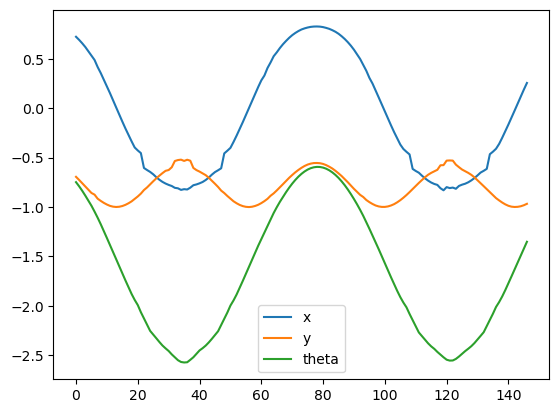

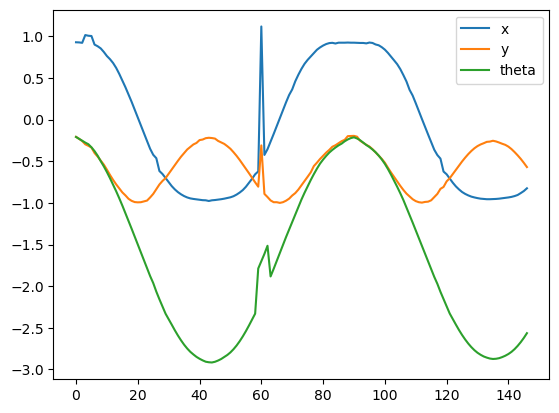

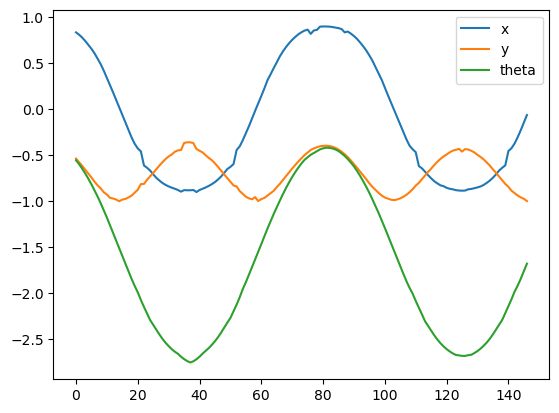

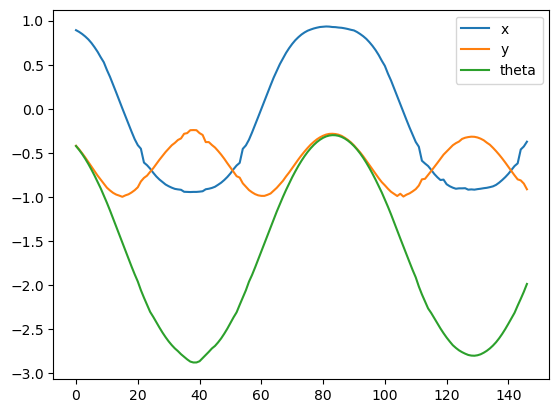

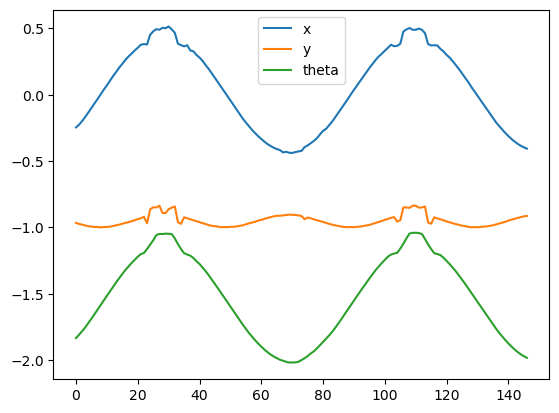

In [96]:
L=1    
smoothening_window_size = 4
#Scaling the pendulum length to L
for df_ in df_trimmed:

    # df_["x"] = df_["x"].rolling(window=smoothening_window_size, center=True).mean()
    # df_["y"] = df_["y"].rolling(window=smoothening_window_size, center=True).mean()

    pen_orig_len = abs(df_["y"]).max()
    df_["x"] = (df_["x"]/pen_orig_len) * L
    df_["y"] = (df_["y"]/pen_orig_len) * L

    # df_["theta"] = np.arctan2(df_["y"], df_["x"])
    df_["theta"] = (np.arctan2(df_["y"], df_["x"])).rolling(window=smoothening_window_size, center=True).mean()
    df_.dropna(ignore_index=True, inplace=True)

df_appended = pd.concat(df_trimmed, ignore_index=True)

for df_ in df_trimmed:
    df_[["x", "y", "theta"]].plot()


In [97]:
(df_appended["x"]**2+df_appended["y"]**2).std()
# (df_appended["x"]**2+df_appended["y"]**2).mean()


0.03143036306106772

<Axes: >

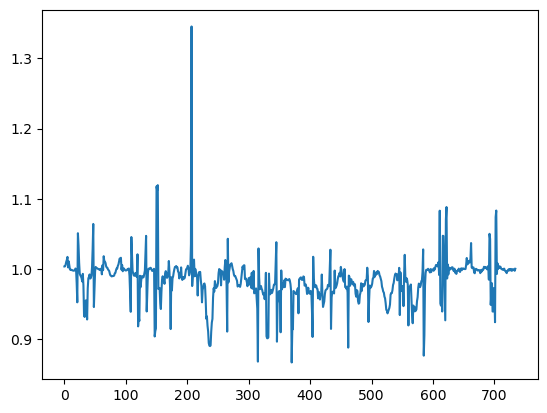

In [98]:
#Visualizing the algebraic constrain in the system
(df_appended["x"]**2+df_appended["y"]**2).plot()


### Finding the first and second order derivative of the states using Savitzky-Golay Filer

In [101]:
# Finding the first and second order derivative of the states using Savitzky-Golay Filer

data_matrix_smooth_df_list = [
    smooth_data(data_matrix,
                domain_var="t",
                smooth_method ="SG",
                noise_perc=0.1,
                derr_order=2,
                polyorder=2,
                window_smooth=None)[20:-20] #trimming zero derivatives near end points
    for data_matrix in df_trimmed]



if len(data_matrix_smooth_df_list) == 1:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0].reset_index(drop=True)
else:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)

data_matrix_df_new= data_matrix_df_smooth_appended[["theta", "d(theta) /dt"]]


data_matrix_df_new = data_matrix_df_new.rename(columns= dict(zip(data_matrix_df_new, ['theta', 'theta_dot'])))

## Fomring the candidate library

In [174]:
import os, sys

path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(path_to_add)
print(os.path.join(path_to_add, "daeFinder"))
sys.path.append(os.path.join(path_to_add, "daeFinder"))

poly_degree = 2
from daeFinder import PolyFeatureMatrix
poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)
# candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)





candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
print("Degree of library: {}".format(poly_degree))
print("# terms in the library: {}".format(candidate_lib_full.shape[1]))

#Optionally removing features from the library
terms_to_drop_corr = set()
candidate_lib_full = candidate_lib_full.drop(terms_to_drop_corr, axis=1)
print("Full candidate library has the following features: {}".format(candidate_lib_full.columns))

#Adding sin and cos terms using x and y
candidate_lib_full["cos(theta)"] = data_matrix_df_smooth_appended["x"]
candidate_lib_full["sin(theta)"] = data_matrix_df_smooth_appended["y"]

/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder
Degree of library: 2
# terms in the library: 5
Full candidate library has the following features: Index(['theta', 'theta_dot', 'theta^2', 'theta theta_dot', 'theta_dot^2'], dtype='object')


In [175]:
# candidate_lib_full["sin(theta)"] = np.sin(candidate_lib_full["theta"])
# candidate_lib_full["cos(theta)"] = np.cos(candidate_lib_full["theta"])


# candidate_lib_full["x"] = df_trimmed[0][100:-100]["x"].reset_index(drop=True)
# candidate_lib_full["y"] = df_trimmed[0][100:-100]["y"].reset_index(drop=True)


<Axes: >

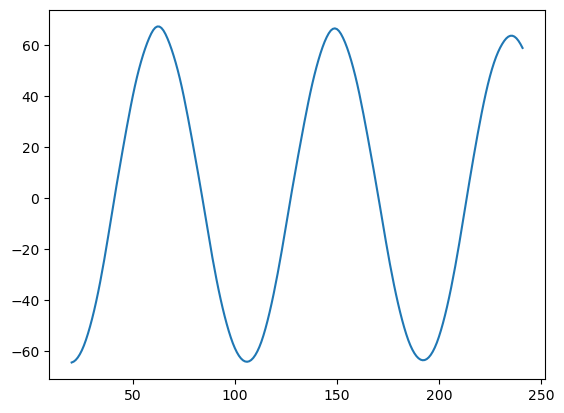

In [176]:
data_matrix_smooth_df_list[0]['d^2(theta) /dt^2'].plot()

In [177]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler with mean=False to keep the mean the same
scaler = StandardScaler(with_std=True, with_mean=False)

# Scale candidate_lib_full
candidate_lib_full_scaled = pd.DataFrame(scaler.fit_transform(candidate_lib_full), columns=candidate_lib_full.columns)

# Scale data_matrix_df_smooth_appended
data_matrix_df_smooth_appended_scaled = pd.DataFrame(scaler.fit_transform(data_matrix_df_smooth_appended), columns=data_matrix_df_smooth_appended.columns)



In [210]:
seq_th_model = sequentialThLin(model_id="lasso" ,fit_intercept=True, alpha=0.002, coef_threshold= 0.06)
# seq_th_model = sequentialThLin(model_id="lasso" ,fit_intercept=True, alpha=0.001, coef_threshold= 0.01)

# seq_th_model = sequentialThLin(fit_intercept=True, model_id="LR", coef_threshold= 0.05)

down_size = 1
X_downsampled = candidate_lib_full_scaled.iloc[::down_size, :].reset_index(drop=True)
y_downsampled = data_matrix_df_smooth_appended_scaled['d^2(theta) /dt^2'].iloc[::down_size].reset_index(drop=True)

seq_th_model.fit(X=X_downsampled, y=y_downsampled)
seq_th_model.score(X=X_downsampled, y=y_downsampled)
# data_matrix_df_smooth_appended["energy"] = 0.5*((data_matrix_df_smooth_appended["x_dot"])**2 + (data_matrix_df_smooth_appended["y_dot"])**2) +  9.81*data_matrix_df_smooth_appended["y"]
# smoothen_index = abs(data_matrix_df_smooth_appended["energy"]-data_matrix_df_smooth_appended["energy"].mean()) < 0.5*data_matrix_df_smooth_appended["energy"].std()
# seq_th_model.fit(X=refined_candid_lib[smoothen_index], y=data_matrix_df_smooth_appended[smoothen_index]['d^2(theta) /dt^2'])

# seq_th_model.score(X=refined_candid_lib[smoothen_index], y=data_matrix_df_smooth_appended[smoothen_index]['d^2(theta) /dt^2'])

Sequential threshold converged in 1 iterations


0.9976598584088451

In [211]:
dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))

{'theta': -0.16752187447484412,
 'theta_dot': 0.0,
 'theta^2': 0.0,
 'theta theta_dot': 0.0,
 'theta_dot^2': 0.0,
 'cos(theta)': -0.8295881879577081,
 'sin(theta)': 0.0}

In [212]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=X_downsampled[["cos(theta)", "theta", "theta_dot"]], y=y_downsampled)
lin_model.score(X=X_downsampled[["cos(theta)","theta", "theta_dot"]], y=y_downsampled)

0.9976774278091848

In [213]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'cos(theta)': -0.8508708709256354,
 'theta': -0.14829113819789283,
 'theta_dot': -0.0034578861258171083}

In [214]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=X_downsampled[["cos(theta)", "theta"]], y=y_downsampled)
lin_model.score(X=X_downsampled[["cos(theta)","theta"]], y=y_downsampled)

0.997665486723187

In [209]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'cos(theta)': -0.6113659993886711, 'theta': -0.3923285665001028}

In [182]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=candidate_lib_full[["cos(theta)"]], y=data_matrix_df_smooth_appended_scaled['d^2(theta) /dt^2'])
lin_model.score(X=candidate_lib_full[["cos(theta)"]], y=data_matrix_df_smooth_appended_scaled['d^2(theta) /dt^2'])

0.997583429977122

In [96]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'cos(theta)': -1.4429552811903108}

## Finding minimum number of data points required

In [99]:
poly_degree = 3
from daeFinder import sequentialThLin
from daeFinder import AlgModelFinder
from daeFinder import remove_paranth_from_feat
# Adding the state variables as scipy symbols

In [100]:
for ind in range(len(df_trimmed)):
    df_trimmed[ind] = df_trimmed[ind][(df_trimmed[ind]['x'].diff().abs() < 0.1) & (df_trimmed[ind]['y'].diff().abs() < 0.1)]
    # df_trimmed[ind] = df_trimmed[ind].sample(frac=1).reset_index(drop=True)

df_appended = pd.concat(df_trimmed).sample(frac=1).reset_index(drop=True)

In [101]:
best_relationship_dict = {}
for num_points in range(50,1000,50):
    # data_matrix_df_new = pd.concat([df_[:num_points][["x","y"]] for df_ in df_trimmed])
    # data_matrix_df_new["Y"] = -data_matrix_df_new["Y"]
    data_matrix_df_new = df_appended[["x","y"]][:num_points]


    from daeFinder import PolyFeatureMatrix
    poly_feature_ob = PolyFeatureMatrix(poly_degree)
    candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)
    # candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)





    candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
    print("Degree of library: {}".format(poly_degree))
    print("# terms in the library: {}".format(candidate_lib_full.shape[1]))

    #Optionally removing features from the library
    terms_to_drop_corr = set()
    candidate_lib_full = candidate_lib_full.drop(terms_to_drop_corr, axis=1)
    print("Full candidate library has the following features: {}".format(candidate_lib_full.columns))


    # feat_list = list(data_matrix_df_smooth_appended.columns)
    feat_list = ["x","y", "theta", "theta_dot"]
    feat_list_str = ", ".join(remove_paranth_from_feat(feat_list))
    exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")


    down_size = 1
    candidate_lib_downsized = candidate_lib_full.iloc[::down_size, :].reset_index(drop=True)


    # seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
    seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.06)

    # seq_th_model = sequentialThLin(model_id="LR", coef_threshold= 0.2)

    algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

    algebraic_model_th.fit(candidate_lib_downsized, scale_columns= True)
    best_lhs = algebraic_model_th.best_models(1).columns[0]
    best_rhs = list((algebraic_model_th.best_models(1)[best_lhs][abs(algebraic_model_th.best_models(1)[best_lhs])>0.001]).index)
    best_relationship_dict[num_points] = (best_lhs, best_rhs)


Degree of library: 3
# terms in the library: 9
Full candidate library has the following features: Index(['x', 'y', 'x^2', 'x y', 'y^2', 'x^3', 'x^2 y', 'x y^2', 'y^3'], dtype='object')
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 0 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Degree of library: 3
# terms in the library: 9
Full candidate library has the following features: Index(['x', 'y', 'x^2', 'x y', 'y^2', 'x^3', 'x^2 y', 'x y^2', 'y^3'], dtype='object')
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshol

In [107]:
num_points = 200
best_relationship_dict[num_points]

('y^2', ['y', 'x^2', 'y^3', 'r2- metric'])

## Checking equivalence of equations

In [108]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=candidate_lib_full[["y", "y^2"]][:num_points], y=candidate_lib_full["x^2"][:num_points])
lin_model.score(X=candidate_lib_full[["y", "y^2"]][:num_points], y=candidate_lib_full["x^2"][:num_points])

0.9929574354259165

In [109]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'y': -0.05278999924816546, 'y^2': -1.0041729648931725}

In [110]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=candidate_lib_full[["y", "y^2","y^3"]][:num_points], y=candidate_lib_full["x^2"][:num_points])
lin_model.score(X=candidate_lib_full[["y", "y^2","y^3"]][:num_points], y=candidate_lib_full["x^2"][:num_points])

0.9929651225204897

In [111]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'y': -0.16030935753288228,
 'y^2': -1.1880511199321695,
 'y^3': -0.09612081883824132}